# Maelstrom example 

#### Simon van Heeringen <s.vanheeringen@science.ru.nl>

These examples will reproduce the results from my poster at the Ninth Annual RECOMB/ISCB Conference on Regulatory & Systems Genomics meeting ([RSG with DREAM 2016](https://www.iscb.org/recomb-regsysgen2016)).


Maelstrom is an ensemble algorithm that was developed with the goal to make differential regulatory motif analysis easy.
It takes as input a set of regions (for instance from ChIP-seq, ATAC-seq or DNaseI experiments) and measurements of two or more experiments (for instance log2-transformed, normalized read counts). 
Alternatively, you can provide labels, for instance from clustering.

This means your input data should look something like this:

```
loc	NK	Monocytes	T-cells	B-cells
chr12:93507547-93507747	3.11846121722	2.52277241968	1.93320358405	0.197177179733
chr7:38236460-38236660	1.0980120443	0.502311376556	0.200701906431	0.190757068752
chr10:21357147-21357347	0.528935300354	-0.0669540487727	-1.04367733597	-0.34370315226
chr6:115521512-115521712	0.406247786632	-0.37661318381	-0.480209252108	-0.667499767004
chr2:97359808-97360008	1.50162092566	0.905358101064	0.719059595262	0.0313480230265
chr16:16684549-16684749	0.233838577502	-0.362675820232	-0.837804056065	-0.746483496024
chrX:138964544-138964744	0.330000689312	-0.29126319574	-0.686082532015	-0.777470189034
chr2:186923973-186924173	0.430448401897	-0.258029531121	-1.16410548462	-0.723913541425
chrX:113834470-113834670	0.560122313347	-0.0366707259833	-0.686082532015	-0.692926848415
```

Or like this:

```
loc	cluster
chr15:49258903-49259103	NK 
chr10:72370313-72370513	NK 
chr4:40579259-40579459	Monocytes
chr10:82225678-82225878	T-cells 
chr5:134237941-134238141	B-cells 
chr5:58858731-58858931	B-cells 
chr20:24941608-24941808	NK 
chr5:124203116-124203316	NK 
chr17:40094476-40094676	Erythroblast
chr17:28659327-28659527	T-cells
```

Both these formats are tab-separated.

Maelstrom will run a variety of algorithms to predict discriminative motifs, and integrate these results using rank aggregation. 


## Prerequisites

Before running this tutorial, make sure that [GimmeMotifs](http://github.com/simonvh/gimmemotifs) is installed.
    
### Install the latest version of GimmeMotifs using Anaconda:
    
```
$ conda install gimmemotifs=0.10.0b4 -c bioconda -c R
```

### Get the hg19 and mm10 genomes:

```
$ mkdir $HOME/genomes/
$ gimme genome $HOME/genomes/ hg19
$ gimme genome $HOME/genomes/ mm10
```

In [2]:
import os
import urllib
import hashlib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr,spearmanr
from sklearn.preprocessing import scale
from gimmemotifs.maelstrom import run_maelstrom

%matplotlib inline

# Ignore warnings (just for clarity of tutorial)
import warnings
warnings.filterwarnings('ignore')

In [4]:
from gimmemotifs.config import MotifConfig
cfg = MotifConfig()
motif_dir = cfg.get_motif_dir()
base_dir = motif_dir.replace("motif_databases", "")
ncpus = int(cfg.get_default_params()["ncpus"])

if ncpus <= 2:
    config_file = os.path.join(base_dir, "gimmemotifs.cfg")
    print "GimmeMotifs currently uses only 2 cores"
    print "If possible, I recommend to change the ncpus paramater in {}".format(config_file)
    

GimmeMotifs currently uses only 2 cores
If possible, I recommend to change the ncpus paramater in /home/simon/anaconda2/share/gimmemotifs/gimmemotifs.cfg


# Get the data!

We'll start by downloading the processed ATAC-seq and RNA-seq in hematopoietic cells, from the data of 
[Corces et al. 2016](http://www.nature.com/ng/journal/v48/n10/full/ng.3646.html) and [Lara-Astasio et al. 2014](http://science.sciencemag.org/content/345/6199/943.long).
Most of these files can be found on NCBI GEO:

* Human ATAC-seq [GSE74912](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74912)
* Human RNA-seq [GSE74246](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE74246)
* Mouse RNA-seq [GSE60101](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE60101)

The GEO submission for the mouse ATAC-seq does not contain a counts table, so we'll download one I have created from figshare: https://figshare.com/articles/GSE59992_counts_table_txt_gz/4159920.

In [5]:
fnames = {
    "GSE74912_ATACseq_All_Counts.txt.gz":
    ("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE74912&format=file&file=GSE74912_ATACseq_All_Counts.txt.gz",
     "8bb507507f17809eb5ea658646263e77"),
    "GSE60101_1256271tableS2.txt.gz":
    ("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE60101&format=file&file=GSE60101_1256271tableS2.txt.gz",
    "88ea3f015fd5e196f39db737770f291d"),
    "GSE74246_RNAseq_All_Counts.txt.gz":
    ("https://www.ncbi.nlm.nih.gov/geo/download/?acc=GSE74246&format=file&file=GSE74246_RNAseq_All_Counts.txt.gz",
     "7cc54350efbd6253192bc29354c4ee33"),
    "GSE59992_counts_table.txt.gz":
    ("https://ndownloader.figshare.com/files/6802764",
    "207437745cb2a1fa6f5986587df0e170"),
    }

for fname, (url, chksum) in fnames.items():
    md5 = ""

    if os.path.exists(fname):
        md5 = hashlib.md5(open(fname).read()).hexdigest()

    # Download file if it doesn't exist, or if is corrupt
    if md5 != chksum: 
        print "Downloading {}".format(fname)
        urllib.urlretrieve (url, fname)

## Read human ATAC-seq table
Maelstrom expects a location as the first column, in `chrom:start-end` format. 
So we'll create this. 
Additionally, we'll update the size of the regions to 200bp instead of the 500bp used in this file. 
For motif analysis, 200bp should be fine and the analysis will run faster.

In [8]:
# Read the file
df = pd.read_table("GSE74912_ATACseq_All_Counts.txt.gz")

# Create regions of 200 bp and combine chromosome, start and end into one column (chrom:start-end)
middle = ((df["Start"] + df["End"]) / 2).astype(int)
df["Start"] = middle - 100
df["End"] = middle + 100
df["loc"] = df["Chr"] + ":" + df["Start"].astype(str) + "-" + df["End"].astype(str)
df = df.set_index("loc")

## Extract relevant data

We'll a few specific cell types, which will be selected on basis of the numerical IDs.
All read counts will be log2-transformed and if there are replicates we'll take the mean.

In [10]:
# Maps experiment codes used in GSE74912 to cell types
exp_map = {
    1: "HSC",
    2: "MPP",
    3: "LMPP",
    4: "CMP", 
    5: "GMP", 
    6: "MEP", 
    7: "Mono",
    9: "CD4", 
    10: "CD8", 
    11: "Nkcell",
    13: "Bcell", 
    14: "CLP",
    15: "Ery", 

}

hg_columns = []
df_avg = pd.DataFrame(index=df.index)
for code,exp in exp_map.items():
    # Get all columns that match the experiment code

    cols = df.columns[df.columns.str.contains(r'({}|-{}[AB])'.format(exp,code))]
    cols = [c for c in cols if not c.startswith("SU")]
    
    # Take the mean of the log2-transformed read count
    df_avg[exp] = np.log2(df[cols] + 1).mean(1)
    hg_columns.append(exp)
df_avg = df_avg[hg_columns]

## Read mouse ATAC-seq table

In [11]:
# Read mouse data
df_mm = pd.read_table("GSE59992_counts_table.txt.gz")
df_mm["loc"] = df_mm["chrom"] + ":" + df_mm["start"].astype(str) + "-" + df_mm["end"].astype(str)
df_mm = df_mm.set_index("loc")

df_mm = df_mm[["Lsk", "CMP", "GMP", "MEP", "Monocytes", "EryA", "CD4", "CD8", "B-cells", "NK"]]
df_mm.columns = ["MPP", "CMP", "GMP", "MEP", "Monocytes", "Erythroblast", "CD4", "CD8", "Bcell", "Nkcell"]

df_mm = np.log2(df_mm + 1)

# Inspect the data

Let's have a look at the data. 
From the boxplots below you'll see that the signal varies a lot between experiments. 
As a quick normalization we will scale the data.

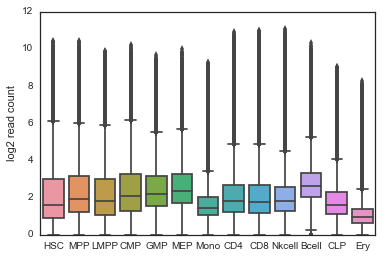

In [12]:
sns.boxplot(df_avg);
plt.ylabel("log2 read count");

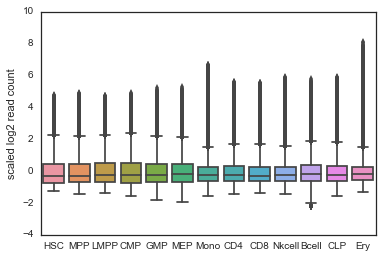

In [13]:
# Normalize
df_avg = df_avg.apply(scale, 0)
sns.boxplot(df_avg);
plt.ylabel("scaled log2 read count");

Let's do the same for the mouse data.

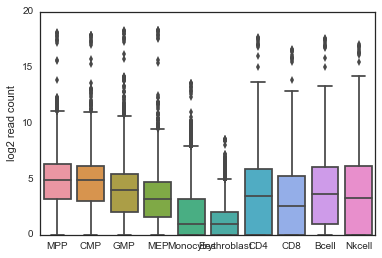

In [14]:
sns.boxplot(df_mm);
plt.ylabel("log2 read count");

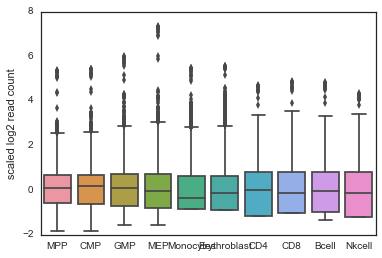

In [15]:
# Normalize
df_mm = df_mm.apply(scale, 0)
sns.boxplot(df_mm);
plt.ylabel("scaled log2 read count");

# Select cell type specific peaks

Here, we select around 10,000 peaks, that are relatively specific for at least one cell type.

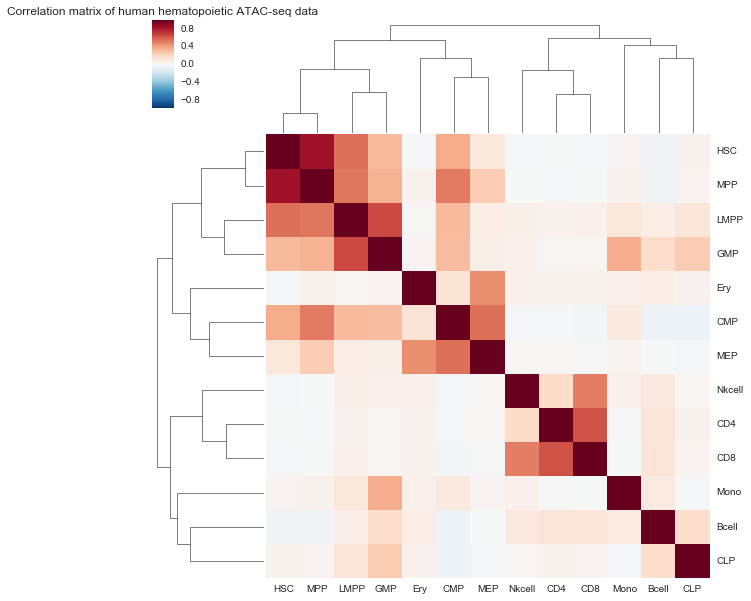

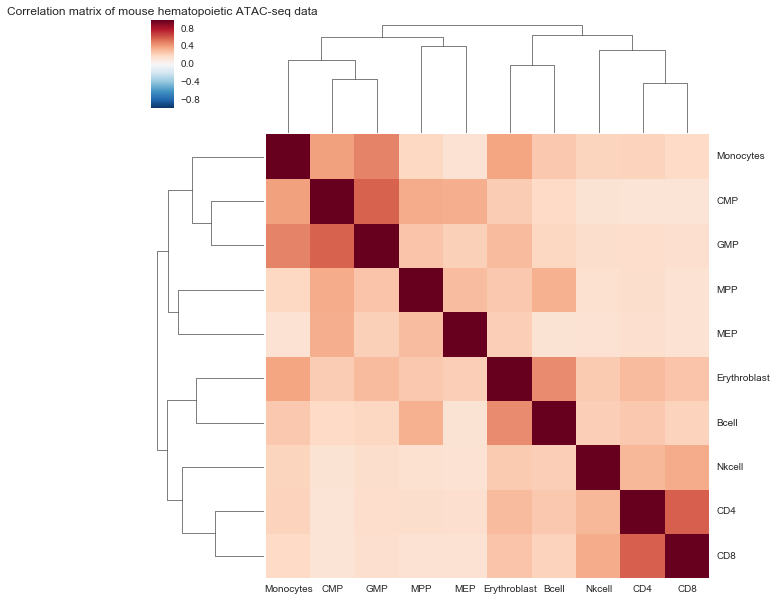

In [19]:
def select_peaks(df, n=10000):
    """
    Select around `n` peaks in total; for each cell type the highest.
    """
    # How many peaks per cell type
    npeaks = 10000 / len(df.columns)
    selection = pd.DataFrame()
    for x in df.columns:
        # All other columns
        others = [c for c in df.columns if not c == x]
        # Difference between column of interest and the highest of the other
        high = df[x] - df[others].max(1)
        # Select the top `npeaks` peaks
        idx = high.sort_values().tail(npeaks).index
        selection = pd.concat((selection, df.loc[idx]))
    return selection

hg_selection = select_peaks(df_avg)
mm_selection = select_peaks(df_mm)

hg_selection.to_csv("hg19.most_variable.10k.txt", sep="\t")  
mm_selection.to_csv("mm10.most_variable.10k.txt", sep="\t")      
    

for name,df in [("human", hg_selection), ("mouse", mm_selection)]:
    fig = plt.figure();
    d = df.corr()
    cm = sns.clustermap(d, cmap="RdBu_r", vmin=-1, vmax=1)
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
    plt.title("Correlation matrix of {} hematopoietic ATAC-seq data".format(name));
    plt.savefig("correlation.matrix.{}.svg".format(name))


# Run maelstrom

Running maelstrom will actually take a while, 
as the methods are not yet optimized for speed in any way. 
The results from my runs are included in this repository. 
If you want to run maelstrom, remove the comments and run the cell. 

You can run maelstrom from the command line in a very similar manner:

```
$ gimme maelstrom hg19.most_variable.10k.txt hg19 test.maelstrom.out
```

The directories `hg19.maelstrom.out` and `mm10.maelstrom.out` contain the results.



In [ ]:
#run_maelstrom("hg19.most_variable.10k.txt", "hg19", "hg19.maelstrom.out")
#run_maelstrom("mm10.most_variable.10k.txt", "mm10", "mm10.maelstrom.out")

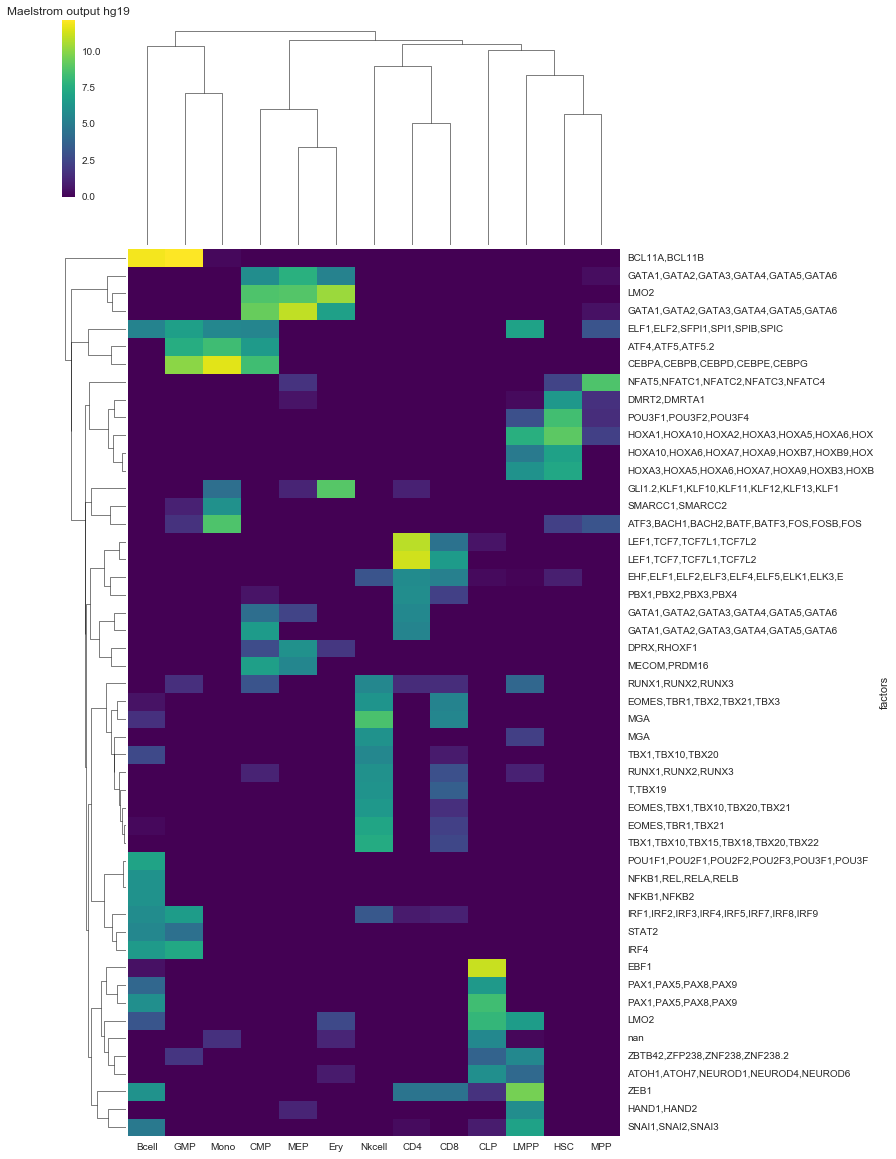

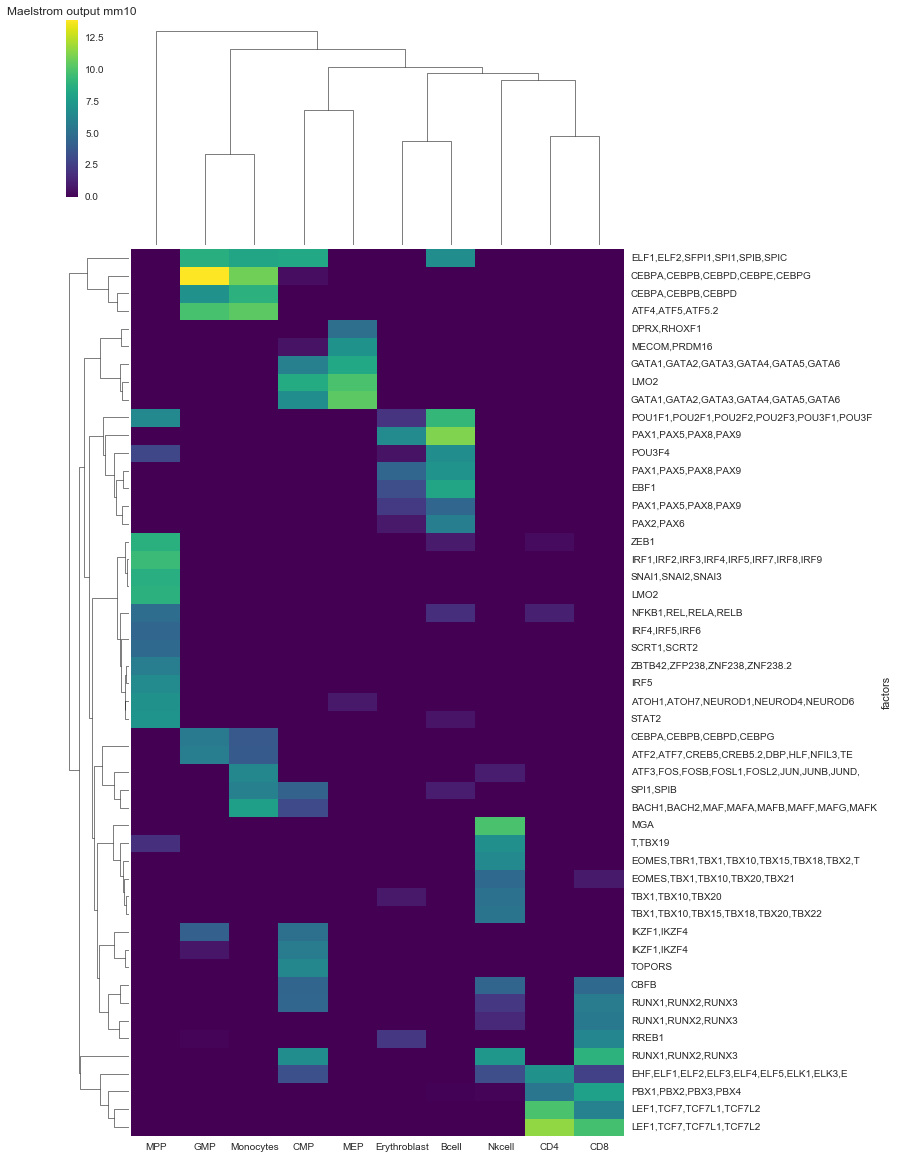

In [17]:
for species in ["hg19", "mm10"]:

    df_result = pd.read_table("{}.most_variable.out/final.out.csv".format(species),
                              index_col=0, comment="#")
    m2f = pd.read_table(os.path.join(motif_dir, "gimme.vertebrate.v3.1.motif2factors.txt"),
                       index_col=0)

    # Truncate for lines with many factors
    m2f["factors"] = m2f["factors"].str.replace(r"(\b(LOC|AL|AC|BX|CR)[0-9\.]+|\w+_XENTR),?", "").str[:40]
    m2f = m2f.dropna()

    f = list(df_result.max(1).sort_values()[-50:].index)
    df_vis = df_result.loc[f].join(m2f).set_index("factors").dropna()

    # Plot heatmap
    cm = sns.clustermap(df_vis, cmap="viridis", figsize=(10,20))

    # Rotate labels
    plt.setp(cm.ax_heatmap.yaxis.get_majorticklabels(), rotation=0);
    plt.title("Maelstrom output {}".format(species))

    plt.savefig("heatmap_motif_activity.{}.svg".format(species))

## Correlation of motifs with TF gene expression

In [20]:
def load_mouse_expression(logtransform=True):
    df_result = pd.read_table("mm10.most_variable.out/final.out.csv", index_col=0, comment="#")
    df_exp = pd.read_table("GSE60101_1256271tableS2.txt.gz",skiprows=1)
    df_exp["NAME"] = df_exp["NAME"].str.upper()
    df_exp = df_exp.set_index("NAME")
    
    
    tr = {
        "B":"Bcell", 
        "CD4":"CD4",
        "CD8":"CD8",
        "NK":"Nkcell",
        "EryA":"Erythroblast",
        "CMP":"CMP",
        "GMP":"GMP",
        "Granulocyte":"Granulocyte",
        "MEP":"MEP",
        "Mono":"Monocytes",
        "MPP":"MPP",
    }

    # Only use cell types for which we have ATAC-seq
    df_exp = df_exp[tr.keys()]
    df_exp.columns = [tr[col] for col in df_exp.columns]
    df_exp = df_exp[df_result.columns] 
    
    if logtransform:
        df_exp = np.log2(df_exp + 1)
    
    return df_exp

In [21]:
def load_human_expression(logtransform=True):
    df_result = pd.read_table("hg19.most_variable.out/final.out.csv", index_col=0, comment="#")
    df_rnaseq = pd.read_table("GSE74246_RNAseq_All_Counts.txt.gz", index_col=0)

    df_exp = pd.DataFrame(index=df_rnaseq.index)
    for code,exp in exp_map.items():
        # Get all columns that match the experiment code
        cols = df_rnaseq.columns[df_rnaseq.columns.str.lower().str.contains(r'({}|-{}[AB])'.format(exp.lower(),code))]
        cols = [c for c in cols if not c.startswith("SU")]
        
        # Take the mean of the log2-transformed read count
        if logtransform:
            df_exp[exp] = np.log2(df_rnaseq[cols] + 1).mean(1)
        else:
            df_exp[exp] = df_rnaseq[cols].mean(1)

    df_exp = df_exp[df_result.columns]
    
    return df_exp

In [24]:
def calc_correlation(df_exp, m2f, genome="hg19", min_exp=0):
    fnames = [
        "final.out.csv",
        "activity.classic.count.out.txt",
        "activity.lightning.score.out.txt",
        "activity.mwu.score.out.txt",
        "activity.rf.score.out.txt",
        "activity.mara.count.out.txt",
        "activity.lasso.score.out.txt"
    ]

    df_map = m2f.copy()
    s = df_map['factors'].str.split(',').apply(pd.Series, 1).stack()
    s.index = s.index.droplevel(-1) # to line up with df's index
    s.name = 'factor' # needs a name to join
    del df_map['factors']
    df_map = df_map.join(s)

    e = df_map.join(df_exp, on="factor")
    e = e[np.any(e.iloc[:,1:] >= min_exp,1)]
    df_corr = e[["factor"]].copy()
    df_map = df_corr.copy()


    for fname in fnames:
        df_test = pd.read_table("{}.most_variable.out/{}".format(genome, fname), index_col=0, comment="#")

        l = len(df_test.columns) 
        m = df_map.join(df_test)

        df_combined = pd.concat((e.iloc[:,1:], m .iloc[:,1:]),1)
        name = fname.replace("activity.", "").replace(".score.out.txt", "").replace(".count.out.txt", "")
        name = name.replace(".out.csv", "")

        df_corr[name] = df_combined.apply(lambda row: pearsonr(row[:l], row[l:])[0], 1)


    df_corr = df_corr.dropna()
    return df_corr


In [23]:
df_exp = {}
df_corr = {}

df_exp["mm10"] = load_mouse_expression()
df_exp["hg19"] = load_human_expression()

for species in df_exp.keys():
    df_corr[species] = calc_correlation(df_exp[species], m2f, species, min_exp=2)
    df_corr[species] = df_corr[species].drop("factor", 1)
    df_corr[species] = df_corr[species].groupby(df_corr[species].index).max()

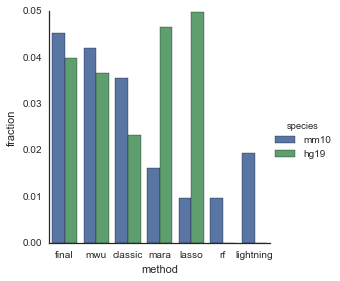

In [28]:
df_fraction = {}
for species in df_exp.keys():
    df_fraction[species] = pd.DataFrame((df_corr[species] >= 0.8).sum() / df_corr[species].shape[0])
    df_fraction[species] = df_fraction[species].reset_index()
    df_fraction[species].columns = ["method", "fraction"]
    df_fraction[species]["species"] = species
    
df_fraction = pd.concat(df_fraction.values())

sns.factorplot(y="fraction", x="method", hue="species", data=df_fraction, kind="bar",
              order=["final", "mwu", "classic", "mara", "lasso", "rf", "lightning"])
plt.savefig("expression_correlation.svg")

## Conservation of motifs between human and mouse

Here we will take the top 10% motifs identified by each methods in both mouse and human and calculate the overlap (Jaccard index; intersection divided by union).

In [30]:
def get_overlap(hg_result, mm_result, cutoff_hg, cutoff_mm, norm=True):
    df_overlap = pd.DataFrame(index=mm_result.columns)
    for c1 in hg_result.columns:
        a = []
        for c2 in mm_result.columns:
            x = set(hg_result[c1][hg_result[c1] >= cutoff_hg].index)
            y = set(mm_result[c2][mm_result[c2] >= cutoff_mm].index)
            if len(x | y) > 0:
                if norm:
                    a.append(len(x & y) / float(len(x | y)))
                else:
                    a.append(len(x & y))
            else:
                a.append(0)
        df_overlap[c1] = a
    return df_overlap

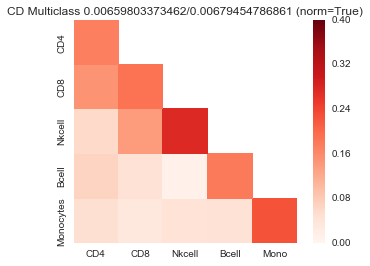

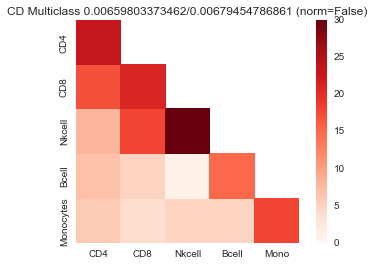

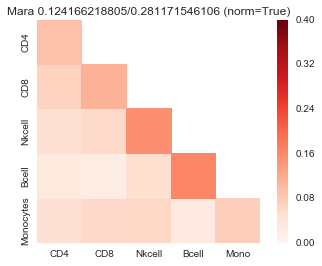

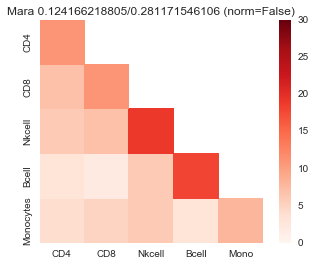

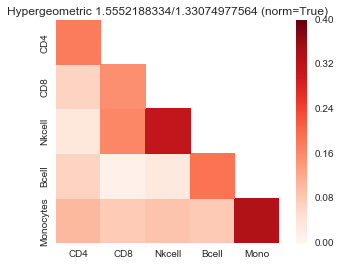

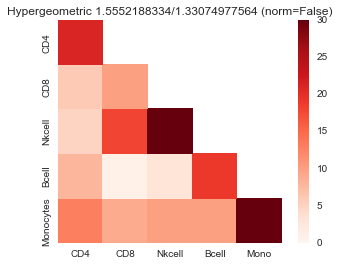

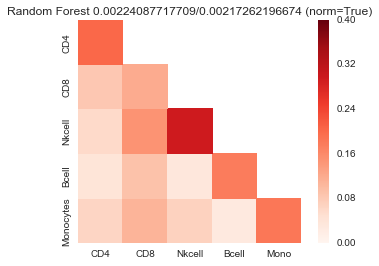

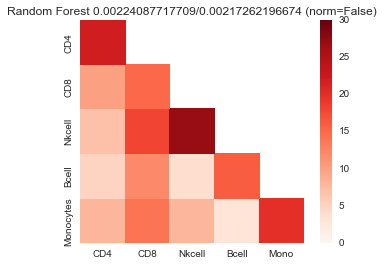

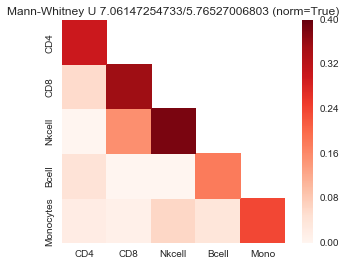

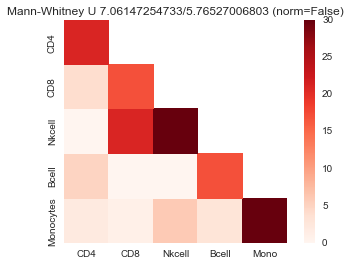

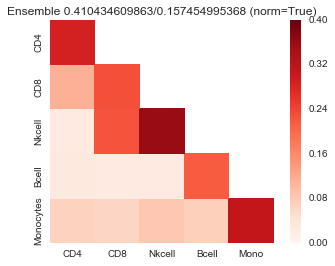

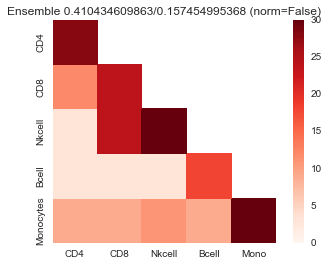

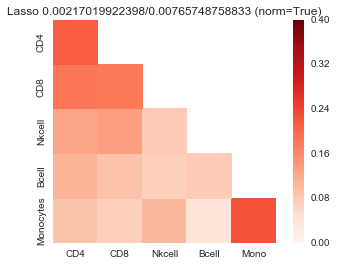

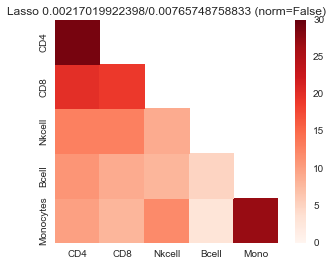

In [32]:
fnames = {
    "Ensemble":"final.out.csv",
    "Hypergeometric":"activity.classic.count.out.txt",
    "CD Multiclass":"activity.lightning.score.out.txt",
    "Mann-Whitney U":"activity.mwu.score.out.txt",
    "Random Forest":"activity.rf.score.out.txt",
    "Mara": "activity.mara.count.out.txt",
    "Lasso": "activity.lasso.score.out.txt",
}

mm_columns = ["CD4", "CD8", "Nkcell", "Bcell", "Monocytes"]
hs_columns = ["CD4", "CD8", "Nkcell", "Bcell", "Mono"]

for name in fnames:
    # Load the data
    mm_result = pd.read_table("mm10.most_variable.out/" + fnames[name], index_col=0, comment="#")
    hg_result = pd.read_table("hg19.most_variable.out/" + fnames[name], index_col=0, comment="#")

    # Get the columns in the same order
    mm_result = mm_result[mm_columns]
    hg_result = hg_result[hs_columns]
    
    # Get the 10% most "significant" motifs
    cutoff_mm = np.percentile(mm_result, 90)
    cutoff_hg = np.percentile(hg_result, 90)
    
    for norm in [True, False]:
        df_overlap = get_overlap(hg_result, mm_result, cutoff_hg, cutoff_mm, norm=norm)
        
        # Generate a mask for the upper triangle
        mask = np.zeros_like(df_overlap, dtype=np.bool)
        mask[np.triu_indices_from(mask, k=1)] = True
        fig = plt.figure()
        if norm:
            sns.heatmap(df_overlap, cmap="Reds", square=True, mask=mask, vmin=0, vmax=0.4)
        else:
            sns.heatmap(df_overlap, cmap="Reds", square=True, mask=mask, vmin=0, vmax=30)
        plt.title("{} {}/{} (norm={})".format(name, cutoff_hg,cutoff_mm, norm))
        plt.savefig("{}{}.svg".format(name, {True:".norm",False:""}[norm]))